In [1]:
import os, warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import cv2, glob, os, pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Camera Calibration

In [3]:
images = glob.glob('./Chessboards/8x6/GO*.jpg')

In [4]:
object_points, image_points = [], []
objp = np.zeros((6 * 8, 3), np.float32)
objp[:, : 2] = np.mgrid[0 : 8, 0 : 6].T.reshape(-1, 2)

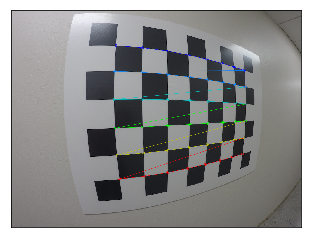

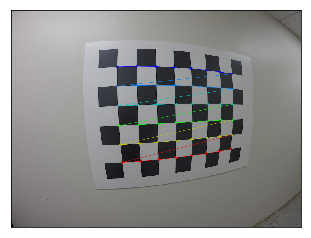

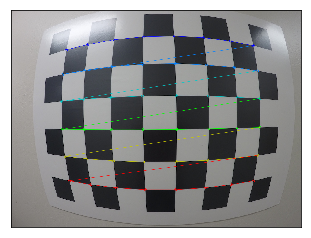

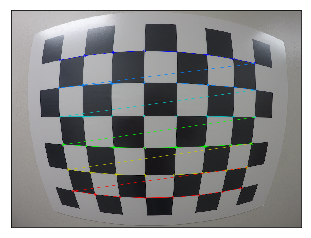

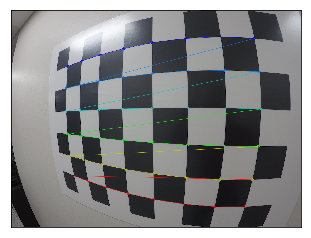

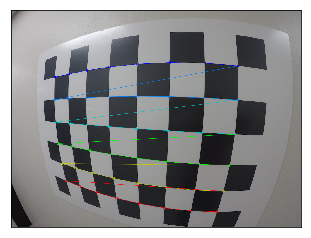

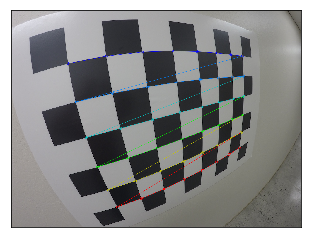

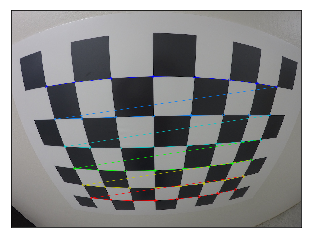

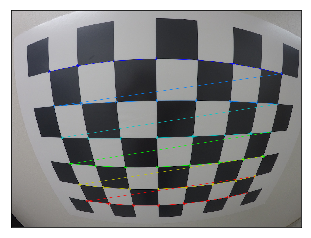

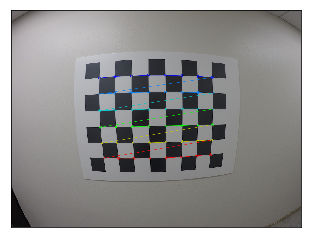

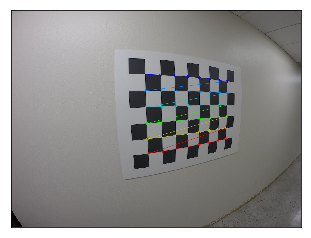

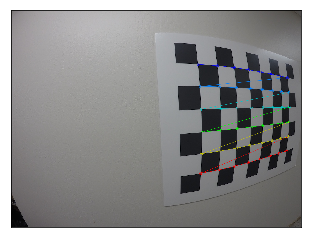

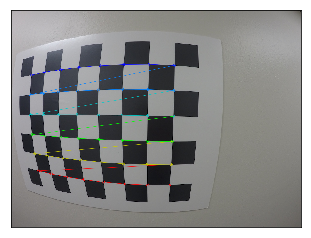

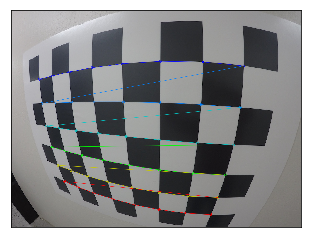

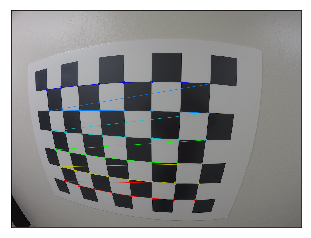

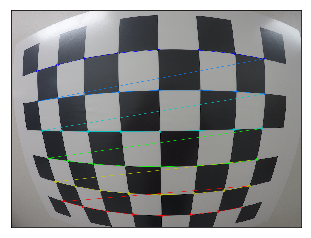

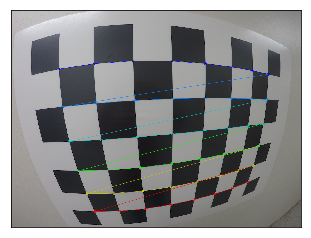

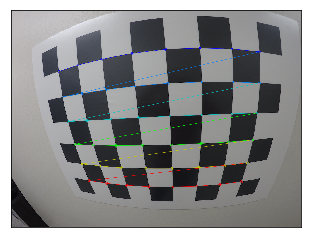

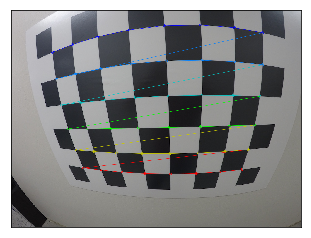

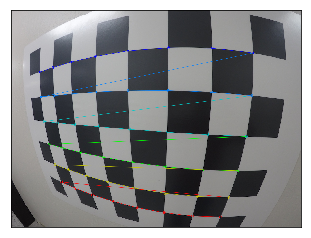

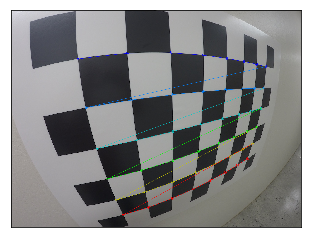

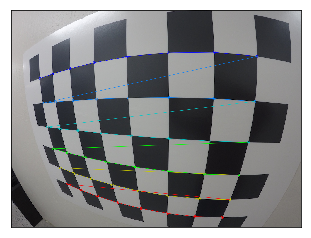

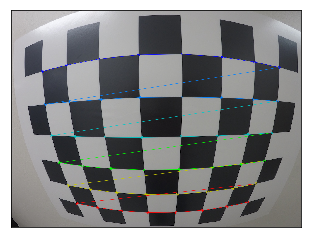

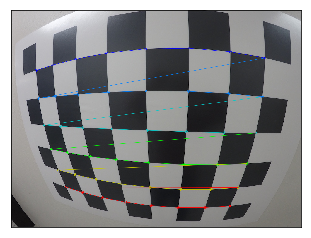

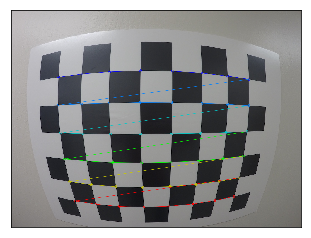

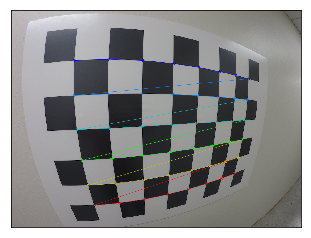

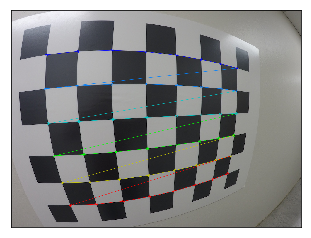

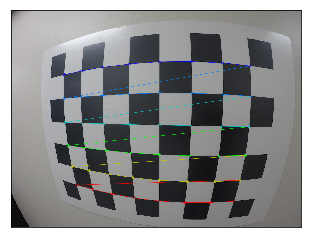

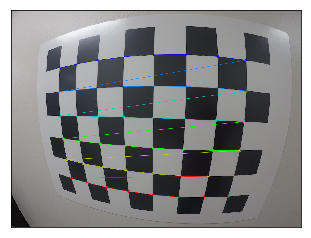

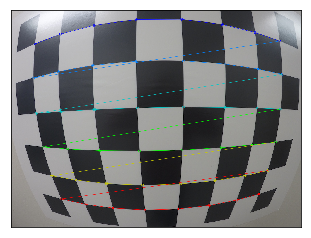

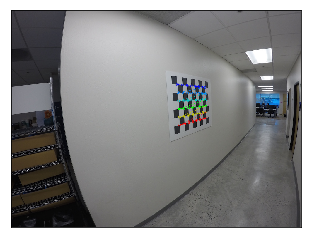

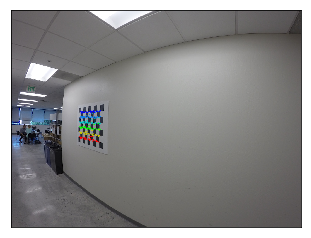

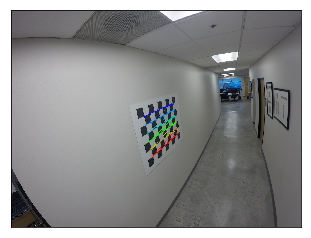

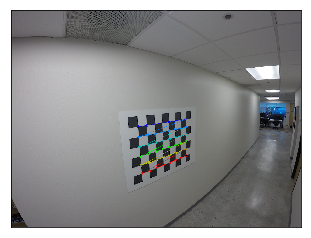

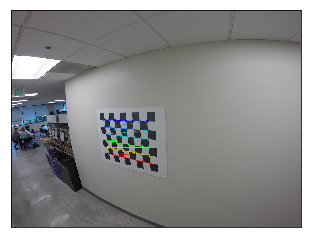

In [5]:
for idx, file_name in enumerate(images):
    img = mpimg.imread(file_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (8, 6), None)
    if ret:
        image_points.append(corners)
        object_points.append(objp)
        img = cv2.drawChessboardCorners(img, (8, 6), corners, ret)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

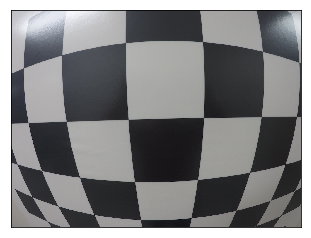

In [6]:
test_image = mpimg.imread('./Chessboards/8x6/test_image.jpg')

plt.imshow(test_image)
plt.xticks([])
plt.yticks([])
plt.show()

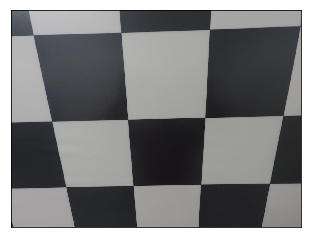

In [7]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points,
                                                   (test_image.shape[1], test_image.shape[0]),
                                                   None, None)

dst = cv2.undistort(test_image, mtx, dist, None, mtx)

plt.imshow(dst)
plt.xticks([])
plt.yticks([])
plt.show()

In [8]:
distortion_object = {}
distortion_object['mtx'] = mtx
distortion_object['dist'] = dist
pickle.dump(distortion_object, open("./wide_dist_pickle.p", "wb" ))

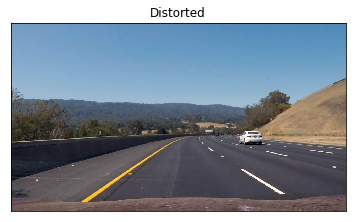

In [9]:
img = mpimg.imread('./Lane Images/test3.jpg')

plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Distorted')
plt.show()

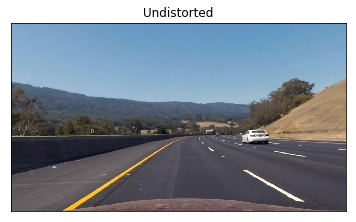

In [10]:
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

plt.imshow(undistorted)
plt.xticks([])
plt.yticks([])
plt.title('Undistorted')
plt.show()

## Warp Road Image

In [11]:
SRC_PTS = [
    [490, 482],
    [810, 482],
    [1250, 720],
    [40, 720]
]

DST_PTS = [
    [0, 0],
    [1280, 0],
    [1250, 720],
    [40, 720]
]

In [12]:
def warp_image(img):

    source = np.float32(SRC_PTS)
    destination = np.float32(DST_PTS)

    # Perspective Transform
    M = cv2.getPerspectiveTransform(source, destination)

    # Inverse of Perspective Transform
    Minv = cv2.getPerspectiveTransform(destination, source)

    # Create warped image using linear interpolation
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

    return warped, M, Minv

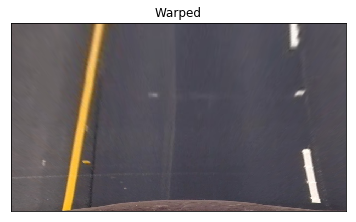

In [13]:
warped, M, Minv = warp_image(undistorted)

plt.imshow(warped)
plt.xticks([])
plt.yticks([])
plt.title('Warped')
plt.show()

## Binarize Road Image

In [14]:
def binarize(img, threshold):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s = hls[:, :, 2]

    luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    l = luv[:, :, 0]

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    b = lab[:, :, 2]

    s_binary = np.zeros_like(s)
    s_binary[(s >= threshold['s']['min']) & (s <= threshold['s']['max'])] = 1

    l_binary = np.zeros_like(l)
    l_binary[(l >= threshold['l']['min']) & (l <= threshold['l']['max'])] = 1

    b_binary = np.zeros_like(b)
    b_binary[(b >= threshold['b']['min']) & (b <= threshold['b']['max'])] = 1

    binary = np.zeros_like(s_binary)
    binary[(l_binary == 1) | (b_binary == 1) | (s_binary == 1)] = 1

    return binary

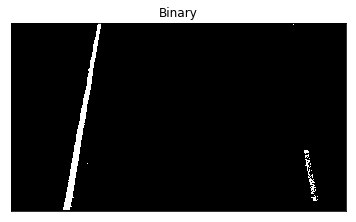

In [15]:
binary = binarize(warped, {
    's' : {
        'min' : 180,
        'max' : 255
    },
    'l' : {
        'min' : 255,
        'max' : 255
    },
    'b' : {
        'min' : 155,
        'max' : 200
    }
})

plt.imshow(binary, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title('Binary')
plt.show()

## Find Lane Lines

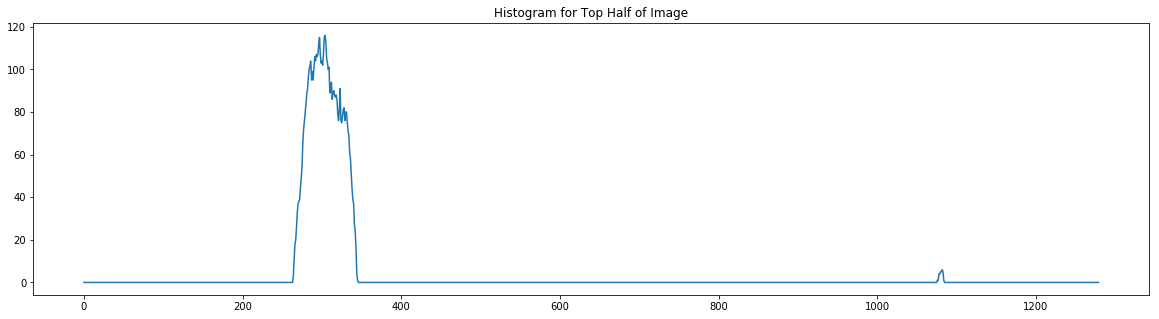

In [16]:
histogram = np.sum(binary[: binary.shape[0] // 2, :], axis = 0)

plt.figure(figsize = (20, 5))
plt.plot(histogram)
plt.title('Histogram for Top Half of Image')
plt.show()

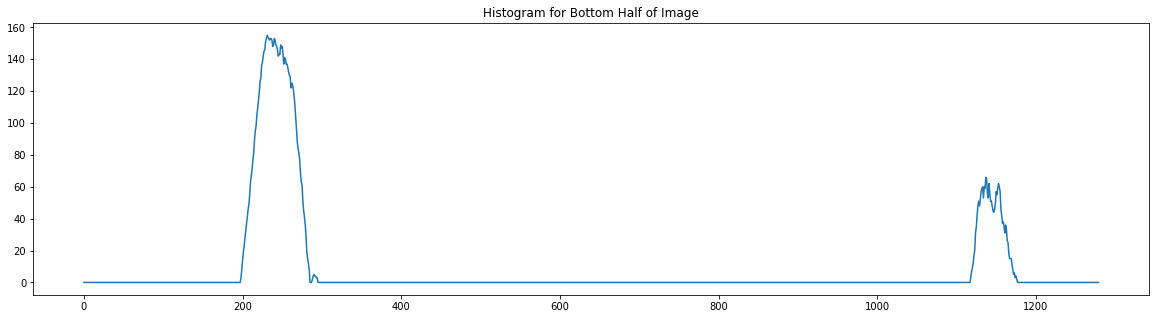

In [17]:
histogram = np.sum(binary[binary.shape[0] // 2:, :], axis = 0)

plt.figure(figsize = (20, 5))
plt.plot(histogram)
plt.title('Histogram for Bottom Half of Image')
plt.show()

In [18]:
output = np.dstack((binary, binary, binary)) * 255
output.shape

(720, 1280, 3)

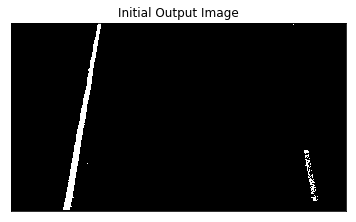

In [19]:
plt.imshow(output)
plt.xticks([])
plt.yticks([])
plt.title('Initial Output Image')
plt.show()

In [20]:
midpoint = np.int(histogram.shape[0] // 2)

# Base Position of Histogram Peaks
leftx_base = np.argmax(histogram[ : midpoint])
rightx_base = np.argmax(histogram[midpoint : ]) + midpoint

In [21]:
windows = 9  # Number of sliding windows
margin = 100 # Width of windows margin
minpix = 50  # Minimum number of pixels searched to recenter the window

In [22]:
nonzero = warped.nonzero()
nonzero_y = np.array(nonzero[0])
nonzero_x = np.array(nonzero[1])

In [23]:
leftx_curr = leftx_base
rightx_curr = rightx_base
left_lane_indices = []
right_lane_indices = []
window_height = np.int(warped.shape[0] // windows)

In [24]:
for window in range(windows):
    win_y_low = warped.shape[0] - (window + 1) * window_height
    win_y_high = warped.shape[0] - window * window_height
    win_xleft_low = leftx_curr - margin
    win_xleft_high = leftx_curr + margin
    win_xright_low = rightx_curr - margin
    win_xright_high = rightx_curr + margin

    cv2.rectangle(output, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
    cv2.rectangle(output, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

    nonzero_left_inds = ((nonzero_y >= win_y_low) &
                         (nonzero_y < win_y_high) &
                         (nonzero_x >= win_xleft_low) &
                         (nonzero_x < win_xleft_high)).nonzero()[0]
    nonzero_right_inds = ((nonzero_y >= win_y_low) &
                          (nonzero_y < win_y_high) &
                          (nonzero_x >= win_xright_low) &
                          (nonzero_x < win_xright_high)).nonzero()[0]

#     left_lane_indices.append(nonzero_left_inds)
#     right_lane_indices.append(nonzero_right_inds)

    if len(nonzero_left_inds) > minpix:
        leftx_curr = np.int(np.mean(nonzero_x[nonzero_left_inds]))
    if len(nonzero_right_inds) > minpix:
        rightx_curr = np.int(np.mean(nonzero_x[nonzero_right_inds]))

    try:
        left_lane_indices = np.concatenate(left_lane_indices)
        right_lane_indices = np.concatenate(right_lane_indices)
    except ValueError:
        pass

    leftx = nonzero_x[left_lane_indices]
    lefty = nonzero_y[left_lane_indices] 
    rightx = nonzero_x[right_lane_indices]
    righty = nonzero_y[right_lane_indices]

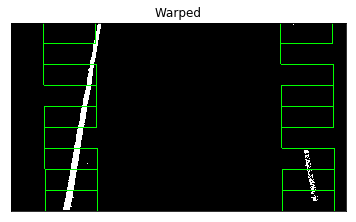

In [25]:
plt.imshow(output, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title('Warped')
plt.show()